# YAMNet Audio Classification Inference with TIDL

This notebook demonstrates an end-to-end audio classification pipeline using YAMNet compiled for TIDL.

**YAMNet Model:**
- AudioSet classification (521 classes)
- Patch-based processing (0.96s per patch)
- Input: Log-mel spectrogram (96 frames × 64 mel bands)
- Quantization: INT8 post-training quantization

## Setup and Configuration

Import required libraries and configure the inference session.

In [1]:
import os

# Suppress ONNX Runtime GPU discovery warning (no GPU on this platform)
os.environ['ORT_DISABLE_DEVICE_DISCOVERY'] = '1'

import sys
import time
import numpy as np
import torch
import soundfile as sf
import onnxruntime as ort
import platform
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import yamnet_infer_audio as yia

# Define SOC and WORK_DIR
SOC = os.environ.get("SOC")
if not SOC:
    print("Warning: SOC environment variable is not defined. Using 'am62a' as default.")
    SOC = 'am62a'
    
# Define WORK_DIR relative to the notebook
WORK_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

print("Successfully imported yamnet_infer_audio as yia")
TIDL_VER = '11_01_06_00'
DEFAULT_MODEL = yia.DEFAULT_MODEL

# Enable debugging only when needed
DEBUG = False

print(f"Setup Complete. SOC='{SOC}', WORK_DIR='{WORK_DIR}'")

Successfully imported yamnet_infer_audio as yia
Setup Complete. SOC='am62a', WORK_DIR='/root/tidl/audioai-modelzoo'


In [2]:
# Configuration parameters
model_name = DEFAULT_MODEL  # 'yamnet_combined'
tensor_bits = 8  # 8 or 16
debug_level = 0  # 0-3 for TIDL execution

base_artifacts_folder = os.path.join(WORK_DIR, 'model_artifacts', TIDL_VER, SOC)
models_base_path = os.path.join(WORK_DIR, 'models', 'onnx')

# Audio file path
audio_file_path = os.path.join(WORK_DIR, 'inference', 'yamnet_sc', 'samples', 'miaow_16k.wav')
print(f"Using audio file: {audio_file_path}")

# Model and artifacts paths
model_path = os.path.join(models_base_path, f"{model_name}.onnx")
print(f"Using model file: {model_path}")

artifacts_path = os.path.join(base_artifacts_folder, f"{model_name}_int{tensor_bits}")
print(f"Using artifacts folder: {artifacts_path}")

# Set environment variables for performance stats
os.environ["TIDL_RT_PERFSTATS"] = "1"
if platform.machine() == 'aarch64':
    os.environ["TIDL_RT_DDR_STATS"] = "1"
    print("TIDL DDR stats enabled.")
else:
    print("Warning: This notebook is optimized for aarch64 platform.")

Using audio file: /root/tidl/audioai-modelzoo/inference/yamnet_sc/samples/miaow_16k.wav
Using model file: /root/tidl/audioai-modelzoo/models/onnx/yamnet_combined.onnx
Using artifacts folder: /root/tidl/audioai-modelzoo/model_artifacts/11_01_06_00/am62a/yamnet_combined_int8
TIDL DDR stats enabled.


## Load and Play Audio

Load the specified audio file and provide playback controls.

In [3]:
waveform_native = None
sr_native = None

# Load audio using soundfile
waveform_np, sr_native = sf.read(audio_file_path, dtype='float32')
# Convert to torch tensor and ensure shape is [channels, samples]
if waveform_np.ndim == 1:
	waveform_np = waveform_np.reshape(1, -1)  # Mono: [1, samples]
else:
	waveform_np = waveform_np.T  # Stereo: [channels, samples]

waveform_native = torch.from_numpy(waveform_np).float()

print(f"Audio loaded successfully: {waveform_native.shape[1]} samples at {sr_native} Hz")
print(f"Duration: {waveform_native.shape[1] / sr_native:.2f} seconds")
print(f"Channels: {waveform_native.shape[0]}")

# Ensure mono for playback
if waveform_native.shape[0] > 1:
	waveform_native = torch.mean(waveform_native, dim=0, keepdim=True)
	print("  Converted to mono for playback.")

# Display audio player
display(Audio(data=waveform_native.numpy(), rate=sr_native))

Audio loaded successfully: 107698 samples at 16000 Hz
Duration: 6.73 seconds
Channels: 1


## Visualize Waveform

Plot the waveform of the loaded audio signal.

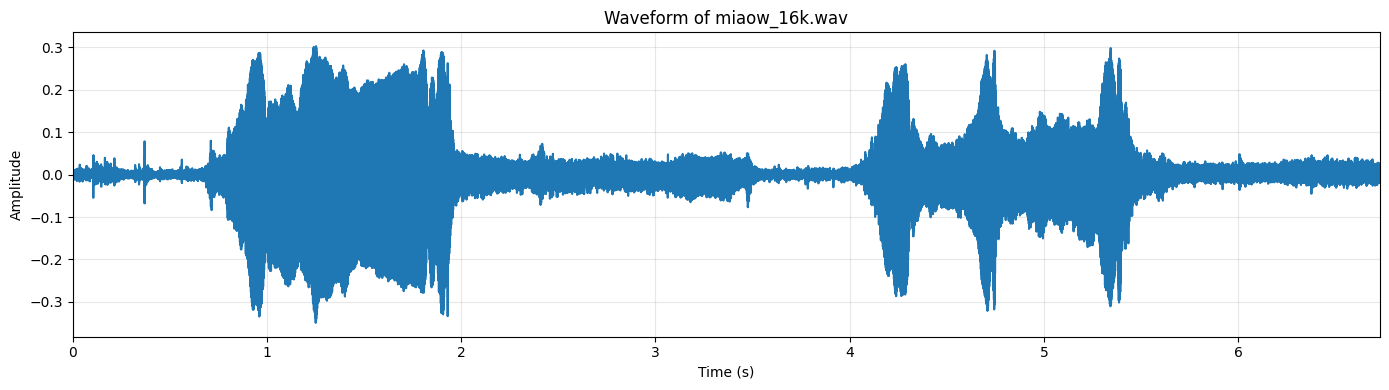

In [4]:
waveform_np = waveform_native.squeeze().numpy()
num_samples = waveform_np.shape[0]
time_axis = torch.linspace(0, num_samples / sr_native, steps=num_samples)

plt.figure(figsize=(14, 4))
plt.plot(time_axis, waveform_np)
plt.title(f'Waveform of {os.path.basename(audio_file_path)}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, num_samples / sr_native])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Preprocess Audio and Extract Features

Convert the audio waveform into log-mel spectrogram patches using the YAMNet preprocessing pipeline.

Each patch represents 0.96 seconds of audio with 96 frames × 64 mel bands.

In [5]:
patches = None
spectrogram = None
preprocess_time = 0

preprocess_start_time = time.time()

# Use the preprocessing function from yamnet_audio_processing module
from yamnet_audio_processing import preprocess_audio_to_patches
patches, spectrogram, sr, duration = preprocess_audio_to_patches(audio_file_path)

preprocess_time = time.time() - preprocess_start_time

print(f"Audio preprocessing completed:")
print(f"  Duration: {duration:.2f}s")
print(f"  Sample rate: {sr} Hz")
print(f"  Patches shape: {patches.shape}")
print(f"  Spectrogram shape: {spectrogram.shape}")
print(f"  Preprocessing time: {preprocess_time*1000:.2f} ms")

Audio preprocessing completed:
  Duration: 6.73s
  Sample rate: 16000 Hz
  Patches shape: (7, 1, 96, 64)
  Spectrogram shape: (674, 64)
  Preprocessing time: 50.97 ms


## Visualize Log-Mel Spectrogram

Display the log-mel spectrogram with patch boundaries marked.

Red dashed lines indicate the boundaries between consecutive 0.96s patches.

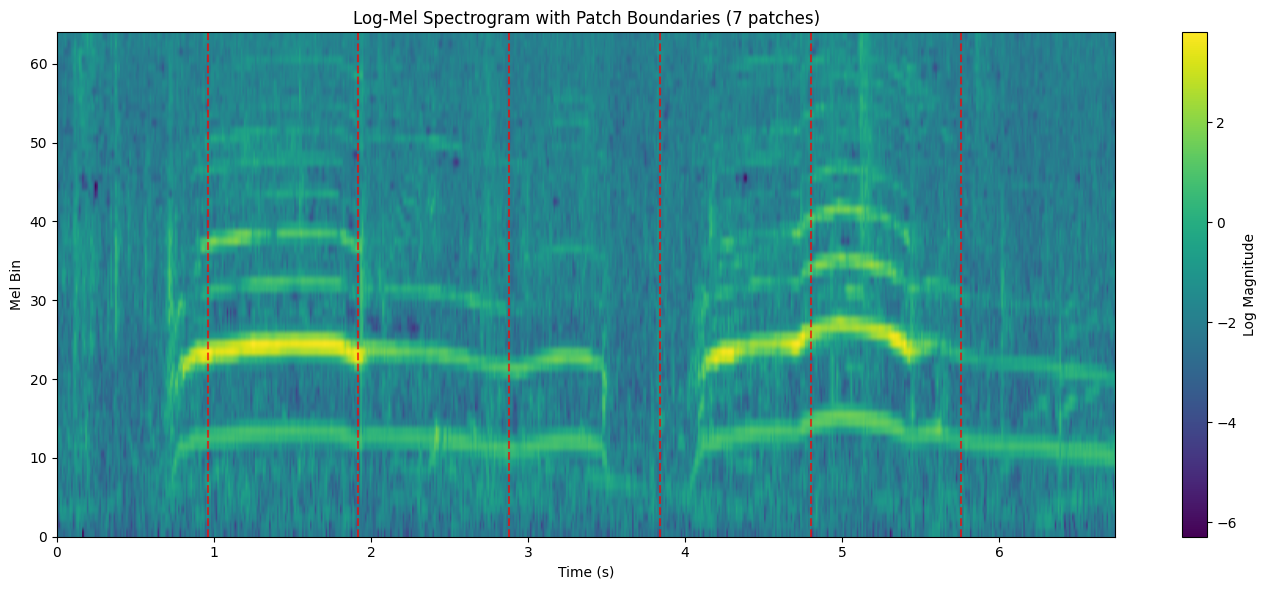

In [6]:
plt.figure(figsize=(14, 6))

# Plot spectrogram
plt.imshow(spectrogram.T, aspect='auto', origin='lower', cmap='viridis',
			extent=[0, spectrogram.shape[0] * 0.01, 0, 64])

# Mark patch boundaries
patch_window_frames = 96  # Each patch has 96 frames
for i in range(1, patches.shape[0]):
	frame_boundary = i * patch_window_frames
	time_boundary = frame_boundary * 0.01  # STFT hop is 0.01s
	plt.axvline(x=time_boundary, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

plt.colorbar(label='Log Magnitude')
plt.title(f'Log-Mel Spectrogram with Patch Boundaries ({patches.shape[0]} patches)')
plt.xlabel('Time (s)')
plt.ylabel('Mel Bin')
plt.tight_layout()
plt.show()

## Run Inference with TIDL

Load the ONNX model using ONNX Runtime with the TIDL delegate and perform inference on all patches.

In [7]:
predictions = None
prediction_results = None
benchmark_results = None
sess = None

try:
	# Load class labels
	from pathlib import Path
	script_dir = Path(__file__).parent if '__file__' in dir() else Path.cwd()
	class_labels_path = script_dir / 'yamnet_class_map.yml'
	class_names = yia.load_class_labels(str(class_labels_path))
	print(f"Loaded {len(class_names)} class labels")
	
	# Set up inference session options
	delegate_options = {
		"artifacts_folder": artifacts_path,
		"debug_level": debug_level
	}
	session_options = ort.SessionOptions()
	session_options.log_severity_level = 3  # Error
	
	print(f"\nSetting up ONNX Runtime session for model: {model_name}")
	print(f"  Artifacts: {artifacts_path}")

	# Create inference session
	EP_list = ['TIDLExecutionProvider', 'CPUExecutionProvider']
	sess = ort.InferenceSession(
		model_path,
		providers=EP_list,
		provider_options=[delegate_options, {}],
		sess_options=session_options
	)
	print("ONNX Runtime session created successfully.")

	# Run inference using imported function
	print(f"\nRunning inference on {patches.shape[0]} patches...")
	predictions, inference_time_ms = yia.run_inference(sess, patches, class_names)
	
	# Generate reports
	prediction_results = yia.aggregate_predictions(predictions, class_names)
	benchmark_results = yia.generate_benchmark_report(sess, inference_time_ms)

except Exception as e:
	print(f"Error during inference: {e}")
	if DEBUG:
		import traceback
		traceback.print_exc()
finally:
	if sess:
		del sess
		print("\nONNX Runtime session released.")

Loaded 521 class labels

Setting up ONNX Runtime session for model: yamnet_combined
  Artifacts: /root/tidl/audioai-modelzoo/model_artifacts/11_01_06_00/am62a/yamnet_combined_int8
ONNX Runtime session created successfully.

Running inference on 7 patches...

Model input: audio, shape: [1, 1, 96, 64]
Model output: class_scores, shape: [1, 521]
Number of patches to process: 7
  Processed patch 1/7 (3.24 ms)
    Top predictions for patch 1:
      1. Speech: -1.789798
      2. Outside, rural or natural: -2.505718
      3. Dog: -2.863677
      4. Animal: -2.863677
      5. Outside, urban or manmade: -2.863677
      6. Domestic animals, pets: -2.863677
      7. Bicycle: -3.221637
      8. Explosion: -3.221637
      9. Bow-wow: -3.579597
      10. Yip: -3.937556
  Processed patch 2/7 (2.56 ms)
    Top predictions for patch 2:
      1. Animal: 1.431839
      2. Domestic animals, pets: -0.357960
      3. Chicken, rooster: -0.357960
      4. Fowl: -0.357960
      5. Livestock, farm animals, work

## Visualize Predictions Across Patches

Display a heatmap showing how the top predicted classes vary across different time patches.

The heatmap shows the top-10 classes (averaged across all patches) and their scores for each individual patch.

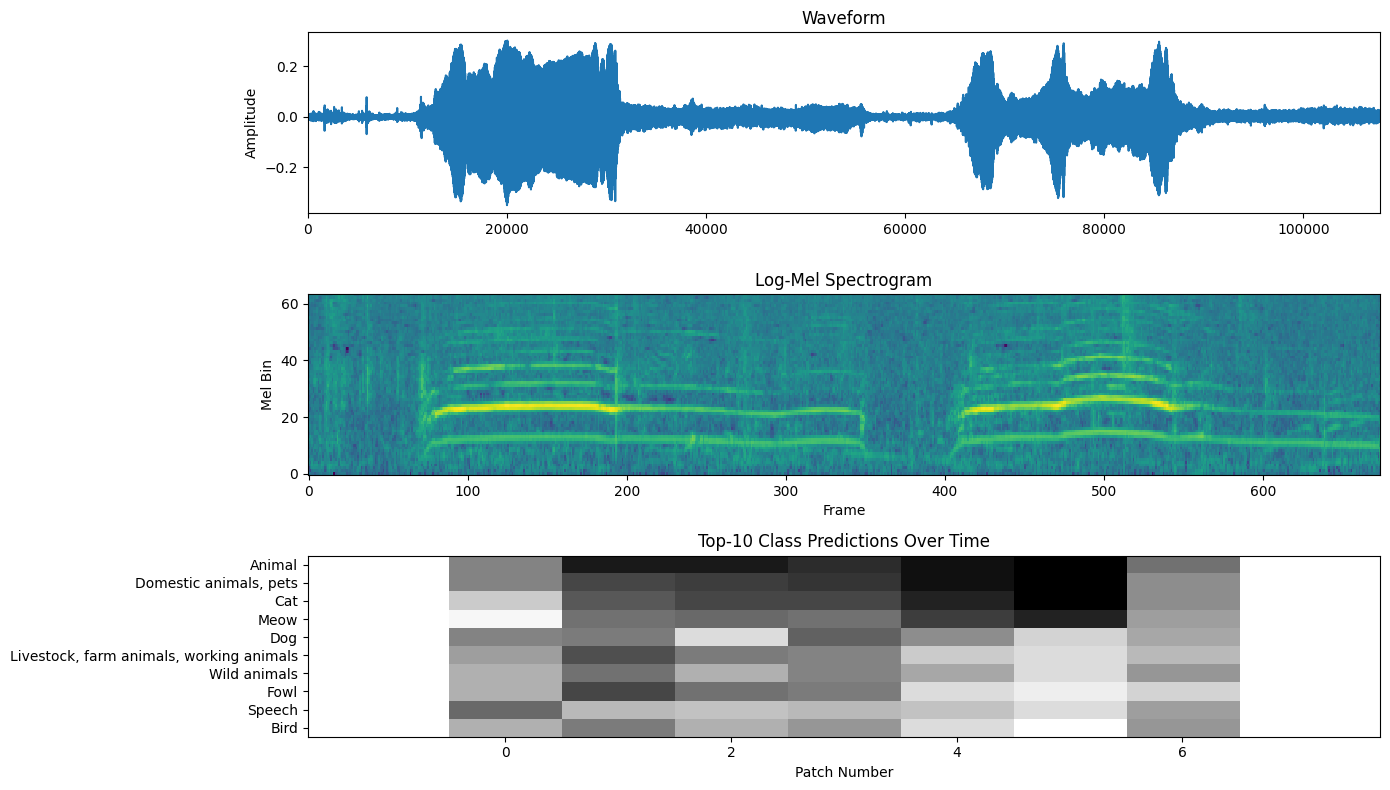

In [8]:
# Get top-10 class indices from aggregated results
top_k = 10
top_indices = [pred['class_index'] for pred in prediction_results['top_predictions'][:top_k]]
top_names = [pred['class_name'] for pred in prediction_results['top_predictions'][:top_k]]

# Extract scores for top classes across all patches
scores_top_classes = predictions[:, top_indices].T  # [top_k, num_patches]

# Get waveform for visualization
waveform_np = waveform_native.squeeze().numpy()

# Create three-panel figure
plt.figure(figsize=(14, 8))

# Plot 1: Waveform
plt.subplot(3, 1, 1)
plt.plot(waveform_np)
plt.xlim([0, len(waveform_np)])
plt.title('Waveform')
plt.ylabel('Amplitude')

# Plot 2: Log-Mel Spectrogram
plt.subplot(3, 1, 2)
plt.imshow(spectrogram.T, aspect='auto', interpolation='nearest', origin='lower')
plt.title('Log-Mel Spectrogram')
plt.ylabel('Mel Bin')
plt.xlabel('Frame')

# Plot 3: Top-k class predictions over time
plt.subplot(3, 1, 3)
plt.imshow(scores_top_classes, aspect='auto', interpolation='nearest', cmap='gray_r')
plt.title(f'Top-{top_k} Class Predictions Over Time')

# Patch padding calculation from YAMNet documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding - 0.5, predictions.shape[0] + patch_padding - 0.5])

# Label the top_k classes
yticks = range(0, top_k, 1)
plt.yticks(yticks, [top_names[x] for x in yticks])
plt.ylim(-0.5 + np.array([top_k, 0]))
plt.xlabel('Patch Number')

plt.tight_layout()
plt.show()


## Summary

Show the top predicted classes averaged across all patches and performance metrics.

In [9]:
print("="*70)
print("YAMNET INFERENCE SUMMARY")
print("="*70)

if prediction_results and benchmark_results:
    print(f"\nAudio File: {os.path.basename(audio_file_path)}")
    print(f"Model: {model_name} (int{tensor_bits})")
    print(f"Number of Patches: {prediction_results['num_patches']}")
    
    print(f"\n{'='*70}")
    print("TOP 10 PREDICTIONS (averaged across all patches):")
    print(f"{'='*70}")
    print(f"{'Rank':<6} {'Score':<10} {'Class'}")
    print("-" * 70)
    
    for pred in prediction_results['top_predictions'][:10]:
        print(f"{pred['rank']:<6} {pred['score']:<10.6f} {pred['class_name']}")
    
    print(f"\n{'='*70}")
    print("PERFORMANCE METRICS:")
    print(f"{'='*70}")
    print(f"Preprocessing Time:     {preprocess_time*1000:>10.2f} ms")
    print(f"Total Inference Time:   {benchmark_results['inference_time_ms']:>10.2f} ms")
    print(f"  Avg per patch:        {benchmark_results['inference_time_ms']/prediction_results['num_patches']:>10.2f} ms")
    print(f"TIDL Processing Time:   {benchmark_results['processing_time_ms']:>10.2f} ms")
    print(f"TIDL Copy Time:         {benchmark_results['copy_time_ms']:>10.2f} ms")
    
    if benchmark_results['ddr_read_MBs'] > 0 or benchmark_results['ddr_write_MBs'] > 0:
        print(f"DDR Read:               {benchmark_results['ddr_read_MBs']:>10.2f} MB/s")
        print(f"DDR Write:              {benchmark_results['ddr_write_MBs']:>10.2f} MB/s")
    
    print(f"{'='*70}")
else:
    print("Inference did not complete successfully. No summary available.")

print("\nNotebook execution completed!")

YAMNET INFERENCE SUMMARY

Audio File: miaow_16k.wav
Model: yamnet_combined (int8)
Number of Patches: 7

TOP 10 PREDICTIONS (averaged across all patches):
Rank   Score      Class
----------------------------------------------------------------------
1      0.409097   Animal
2      -0.255686  Domestic animals, pets
3      -1.022742  Cat
4      -2.352306  Meow
5      -3.835282  Dog
6      -3.886419  Livestock, farm animals, working animals
7      -4.090968  Wild animals
8      -4.193242  Fowl
9      -4.704612  Speech
10     -4.755750  Bird

PERFORMANCE METRICS:
Preprocessing Time:          50.97 ms
Total Inference Time:        17.53 ms
  Avg per patch:              2.50 ms
TIDL Processing Time:         1.70 ms
TIDL Copy Time:               0.11 ms
DDR Read:                     0.21 MB/s
DDR Write:                    5.46 MB/s

Notebook execution completed!
